# Isprobavanje multi label classifiera


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time
from datetime import datetime

plt.ion()   # interactive mode

In [3]:
# Access to uploaded files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_prefix = 'drive/My Drive/Colab Notebooks/Diplomski'
values = ['no', 'yes']

In [5]:
class MultiLabelToothDataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, target_transform=None, subset=None):
    self.subset = subset
    self.df = pd.read_csv(csv_file, sep = ";")
    if self.subset: self.df = self.subset(self.df)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    self.ret_indx = False

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(self.img_dir, img_name)
    image = Image.open(img_path)
    #image = read_image(img_path)
    label = row
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    if self.ret_indx: return image, label, torch.tensor(idx)    
    return image, label

class MultiLabelToTensor(object):
  def __init__(self, attrs_of_interest):
    self.attrs_of_interest = attrs_of_interest
  
  def __call__(self, row):
    return torch.tensor([1.0 if row[x] == 'yes' else 0.0 for x in self.attrs_of_interest])

In [6]:
def keep_only_subset(df, num_of_total_negatives=-1, num_of_positives=-1):
  df_some_yes = df[~((df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no'))]
  df_all_no = df[(df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no')]
  if num_of_total_negatives >= 0:
    df_all_no = df_all_no.sample(n=num_of_total_negatives, random_state=1)
  if num_of_positives >= 0:
    df_some_yes = df_some_yes.sample(n=num_of_positives, random_state=1)
  print(f'len(df_some_yes): {len(df_some_yes)}, len(df_all_no): {len(df_all_no)}')
  return pd.concat([df_some_yes,df_all_no]).copy()

In [7]:
attrs_of_interest = ['bridge', 'endofilling', 'filling', 'crown']
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image_datasets = dict()
dataloaders = dict()
dataset_sizes = dict()
class_names = dict()

csv_filename = os.path.join(dir_prefix, 'multi_label_dataset/tooth_info.csv')
img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
dataset = MultiLabelToothDataset(csv_filename, 
                                 img_dir,
                                 transform=img_transforms,
                                 target_transform=MultiLabelToTensor(attrs_of_interest),
                                 subset=lambda df: keep_only_subset(df, num_of_total_negatives=9000)
                                )
total_number = len(dataset)
split_size = [int(total_number * 0.7), total_number - int(total_number * 0.7)]
dataset_train, dataset_val = random_split(dataset, split_size, generator=torch.Generator().manual_seed(42))

image_datasets = {'train': dataset_train, 'val': dataset_val}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = attrs_of_interest

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

len(df_some_yes): 8790, len(df_all_no): 9000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
print(class_names)
df_sub = dataset.df
ratio = {x: len(df_sub[df_sub[x] == 'no'])/len(df_sub[df_sub[x] == 'yes']) for x in attrs_of_interest}
print(ratio)
pos_weight = torch.tensor([ratio[x] for x in attrs_of_interest])
pos_weight = pos_weight.to(device)
print(pos_weight)

['bridge', 'endofilling', 'filling', 'crown']
{'bridge': 33.81409001956947, 'endofilling': 8.44267515923567, 'filling': 1.6215738284703802, 'crown': 11.475455820476858}
tensor([33.8141,  8.4427,  1.6216, 11.4755], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


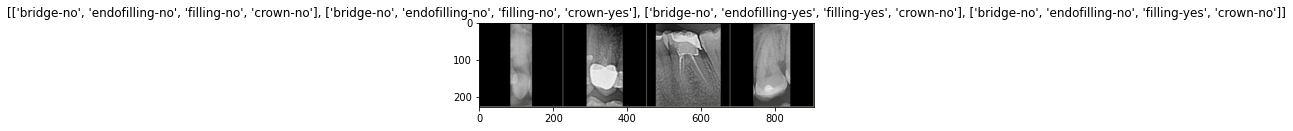

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[[f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(labels)] for labels in classes])



In [ ]:
def train_model(model, criterion, optimizer, scheduler, THRES, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds =  (torch.sigmoid(outputs) > THRES)* 1.0

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * len(attrs_of_interest))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, THRES, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > THRES)* 1.0

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format([f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(preds[j])], [f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(labels.data[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
num_epochs=15
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       THRES=0.5, num_epochs=num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5143 Acc: 0.8561
val Loss: 0.2766 Acc: 0.9183

Epoch 1/14
----------
train Loss: 0.3086 Acc: 0.9137
val Loss: 0.2518 Acc: 0.9375

Epoch 2/14
----------
train Loss: 0.2368 Acc: 0.9352
val Loss: 0.2256 Acc: 0.9485

Epoch 3/14
----------
train Loss: 0.2045 Acc: 0.9455
val Loss: 0.3473 Acc: 0.8960

Epoch 4/14
----------
train Loss: 0.1761 Acc: 0.9533
val Loss: 0.2252 Acc: 0.9500

Epoch 5/14
----------
train Loss: 0.1551 Acc: 0.9595
val Loss: 0.2548 Acc: 0.9615

Epoch 6/14
----------
train Loss: 0.1257 Acc: 0.9680
val Loss: 0.2556 Acc: 0.9629

Epoch 7/14
----------
train Loss: 0.0973 Acc: 0.9782
val Loss: 0.2309 Acc: 0.9656

Epoch 8/14
----------
train Loss: 0.0968 Acc: 0.9795
val Loss: 0.2347 Acc: 0.9644

Epoch 9/14
----------
train Loss: 0.0770 Acc: 0.9807
val Loss: 0.2481 Acc: 0.9661

Epoch 10/14
----------
train Loss: 0.0727 Acc: 0.9825
val Loss: 0.2383 Acc: 0.9654

Epoch 11/14
----------
train Loss: 0.0828 Acc: 0.9824
val Loss: 0.2662 Acc: 0.9657

Epoch 12/14
----------
t

In [ ]:
# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

torch.save(model_ft, os.path.join(dir_prefix, f'multilabel_model-{dt_string}-epochs-{num_epochs}'))

In [8]:
# Load the model 

model = torch.load(os.path.join(dir_prefix, 'multilabel_model-21:12:2021-22:27:30-epochs-15'))
model.eval()
model_ft = model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


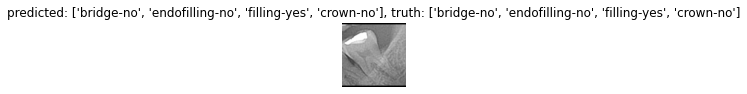

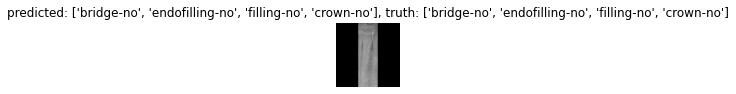

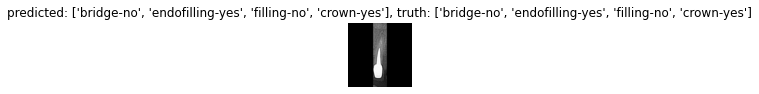

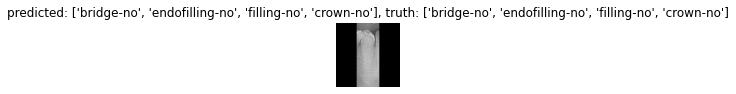

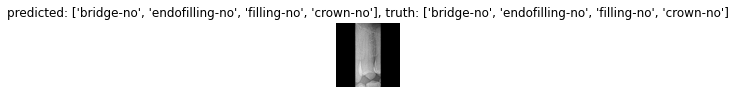

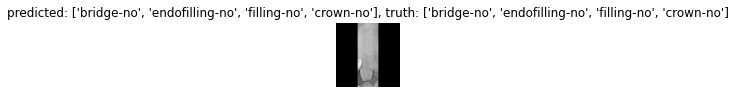

In [ ]:
visualize_model(model_ft, THRES=0.5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

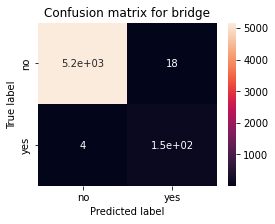

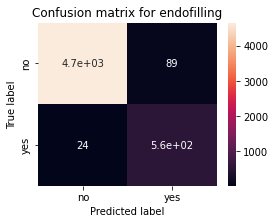

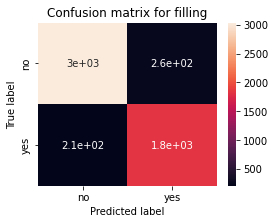

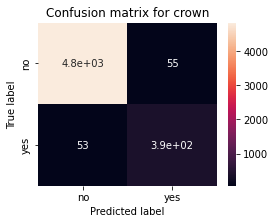

In [12]:
for i,attr in enumerate(attrs_of_interest):
  y_pred = []
  y_true = []

  was_training = model_ft.training
  model_ft.eval()

  with torch.no_grad():
  # iterate over test data
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      preds =  (torch.sigmoid(outputs) > .5) * 1.0

      outputs = (preds[:, i]).data.cpu().numpy()
      y_pred.extend(outputs) # Save Prediction
      
      labels = (labels[:, i]).data.cpu().numpy()
      y_true.extend(labels) # Save Truth
  
  model_ft.train(mode=was_training)

  # constant for classes
  classes = ('no', 'yes')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  # Columns (True labels) sum to 100%
  # df_cm = pd.DataFrame(cf_matrix / np.reshape(np.sum(cf_matrix, axis=0), (1,2)), index = [i for i in classes],
  #                     columns = [i for i in classes])
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                    columns = [i for i in classes])
  plt.figure(figsize = (4,3))
  sn.heatmap(df_cm, annot=True)
  plt.title(f'Confusion matrix for {attr}')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

  plt.savefig(f'{dir_prefix}/graphics/multilabel_model-{attr}-confusion_matrix-{dt_string}.png', dpi=1000)

In [13]:
dataset.ret_indx = True
dataset_train, dataset_val2 = random_split(dataset, split_size, generator=torch.Generator().manual_seed(42))

dataloader_last = torch.utils.data.DataLoader(dataset_val2, batch_size=1, shuffle=False, num_workers=4)

y_pred_right = []
y_pred = []
y_true = []
val_indxs = []
i = 0
for inputs, labels, indx in dataloader_last:
  inputs = inputs.to(device)
  labels = labels.to(device)
  val_indxs.append(int(indx))
  outputs = model_ft(inputs)
  preds =  (torch.sigmoid(outputs) > .5) * 1.0

  outputs = (preds).data.cpu().numpy()
  y_pred.extend(outputs)
  y_true.extend((labels).data.cpu().numpy())
  # if i == 10: break
  # i += 1

y_pred_right = np.array(y_pred_right)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

anal_df = dataset.df.iloc[val_indxs].copy()


for i, c in enumerate(class_names):
  anal_df[f'predicted-{c}'] = y_pred[:, i]
  anal_df[f'true-{c}'] = y_true[:, i]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
# Shortcut to get anal_df
# pandas dataset to analyse predictions made by my neural net
# anal_df.to_pickle(f'{dir_prefix}/pickeled_pandas/anal_df.pkl')

anal_df = pd.read_pickle(f'{dir_prefix}/pickeled_pandas/anal_df.pkl')

In [10]:
def rows_where_mismatch(df, at):
  return df[df[f'predicted-{at}'] != df[f'true-{at}']]

def just_tooth(df, quad, index):
  return df[(df['quad'] == int(quad)) & (df['index'] == int(index))]


print(anal_df.columns)
w_fill = rows_where_mismatch(anal_df, 'filling')

print(w_fill.head())
print(len(w_fill))

Index(['image_identifier', 'image_md5', 'id_hash', 'age', 'sex', 'quad',
       'index', 'status_shorthand', 'x1', 'y1', 'x2', 'y2', 'missing', 'germ',
       'root', 'implant', 'bridge', 'endofilling', 'filling', 'crown',
       'tooth_decay', 'appliance', 'img_name', 'tooth_id', 'center_x',
       'center_y', 'width', 'height', 'predicted-bridge', 'true-bridge',
       'predicted-endofilling', 'true-endofilling', 'predicted-filling',
       'true-filling', 'predicted-crown', 'true-crown'],
      dtype='object')
                                        image_identifier  ... true-crown
20194        smooth-political-shiny-murky-magnificent-go  ...        0.0
176    stereotyped-stingy-silky-knotty-inexpensive-fo...  ...        0.0
10010       knowing-learned-elastic-educated-jolly-claim  ...        0.0
24141   hospitable-glib-regular-windy-boundless-teaching  ...        0.0
3795   faithful-clear-ashamed-obtainable-watery-comfo...  ...        0.0

[5 rows x 36 columns]
462


In [13]:
# Save info about misclassified teeth
# because among teeth misclassified by model there is
# a very high proportion of questionably labeled teeth

for attr in attrs_of_interest:
  w_attribute = rows_where_mismatch(anal_df, f'{attr}')
  #w_attribute = w_attribute[['image_identifier', 'image_md5', 'tooth_id', 'predicted-bridge', 'true-bridge', 'predicted-crown', 'true-crown', 'predicted-filling', 'true-filling', 'predicted-endofilling', 'true-endofilling']]
  w_attribute.to_csv(f'{dir_prefix}/misclassified_teeth/misclassified_teeth-{attr}.csv', index=False)

In [22]:
cnt = 0
true_bridge = anal_df[anal_df['true-bridge'] == 1.0]
for idx_row in true_bridge.iterrows():
  row = idx_row[1]
  img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
  img_path = os.path.join(img_dir, img_name)
  image = Image.open(img_path)
  print(f"{img_name}\ntrue-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}")
  display(image)
  cnt += 1
  if cnt == 100: break
  print()
print()
print()
print()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
cnt = 0
true_bridge_and_crown = anal_df[(anal_df['true-bridge'] == 1.0) & (anal_df['true-crown'] == 1.0)]
print(len(true_bridge_and_crown))
for idx_row in true_bridge_and_crown.iterrows():
  row = idx_row[1]
  img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
  img_path = os.path.join(img_dir, img_name)
  image = Image.open(img_path)
  print(f"{img_name}\ntrue-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}")
  display(image)
  cnt += 1
  if cnt == 100: break
  print()
print()
print()
print()

0





In [24]:
cnt = 0
true_crown = anal_df[anal_df['true-crown'] == 1.0]
print(len(true_crown))
for idx_row in true_crown.iterrows():
  row = idx_row[1]
  img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
  img_path = os.path.join(img_dir, img_name)
  image = Image.open(img_path)
  print(f"{img_name}\ntrue-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}")
  display(image)
  cnt += 1
  if cnt == 100: break
  print()
print()
print()
print()

Output hidden; open in https://colab.research.google.com to view.

In [14]:
sus_teeth = [(1, 4), (2, 1), (2, 7), (4, 5), (2, 6), (4,6), (1,6), (3,7), (4,8), ]
for sus_tooth in sus_teeth:
  print(f'Tooth: {sus_tooth[0]}-{sus_tooth[1]}')
  curr_w_fill = just_tooth(w_fill, quad=sus_tooth[0], index=sus_tooth[1])
  fp = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 1) & (curr_w_fill['true-filling'] == 0)])
  fn = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 0) & (curr_w_fill['true-filling'] == 1)])
  fp_explained_by_endofilling = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 1) & (curr_w_fill['predicted-endofilling'] == 1) & (curr_w_fill['true-endofilling'] == 1)])
  fn_explained_by_endofilling = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 0) & (curr_w_fill['predicted-endofilling'] == 1)])
  print(f'fp_explained_by_endofilling: {fp_explained_by_endofilling}/{fp}')
  print(f'fn_explained_by_endofilling: {fn_explained_by_endofilling}/{fn}')
  print()

Tooth: 1-4
fp_explained_by_endofilling: 5/15
fn_explained_by_endofilling: 3/9

Tooth: 2-1
fp_explained_by_endofilling: 0/9
fn_explained_by_endofilling: 2/13

Tooth: 2-7
fp_explained_by_endofilling: 3/14
fn_explained_by_endofilling: 4/13

Tooth: 4-5
fp_explained_by_endofilling: 2/10
fn_explained_by_endofilling: 1/10

Tooth: 2-6
fp_explained_by_endofilling: 4/20
fn_explained_by_endofilling: 1/6

Tooth: 4-6
fp_explained_by_endofilling: 7/15
fn_explained_by_endofilling: 1/9

Tooth: 1-6
fp_explained_by_endofilling: 5/15
fn_explained_by_endofilling: 2/8

Tooth: 3-7
fp_explained_by_endofilling: 2/12
fn_explained_by_endofilling: 2/11

Tooth: 4-8
fp_explained_by_endofilling: 2/5
fn_explained_by_endofilling: 0/10



Images of teeth: 4-6, num of imgs: 13
smooth-political-shiny-murky-magnificent-go_7fab4badb02e2a92e5d589e29abd782e--m_4_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


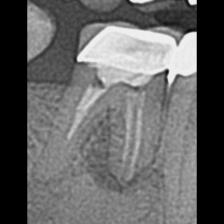


strange-lewd-filthy-flowery-possible-hell_8d208ece09fb4a14a22739451de1e74b--m_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


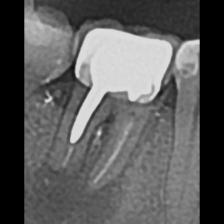


average-inquisitive-narrow-jolly-barbarous-magazine_b8802cb226a83e0ff650a06fb49c3c49--m_4_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


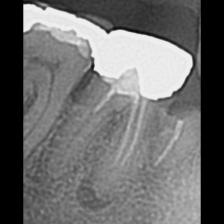


abashed-majestic-adhesive-sore-earsplitting-lab_9f1cf41ed14fbf43526e94d3b2d9bcd4--f_4_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


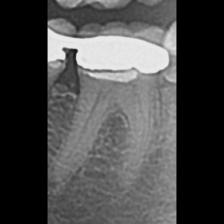


motionless-husky-wooden-observant-bewildered-mine_0fb564815917c5c5152fb7b4f2a18f91--m_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


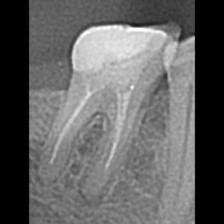


graceful-scarce-damaging-aboard-meaty-credit_d9daeae595dec4deb58135b78aecdc54--m_4_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


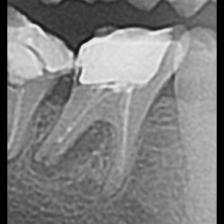


substantial-questionable-keen-stale-organic-year_9274bbdd575dcdde253b488e1e828d45--f_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


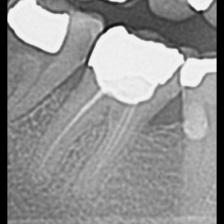


shy-frantic-honorable-longing-sneaky-site_4006140350fa736588c3031c037091a7--f_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


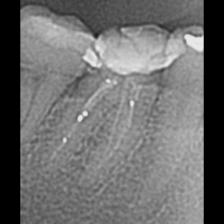


heavy-misty-glib-bright-rotten-many_eb609d6fbc53438e7c66b9523916aa03--m_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


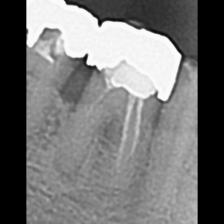


secretive-tenuous-minor-aspiring-obscene-tell_5979a3e65a98e6dec903e7b230d277fb--f_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


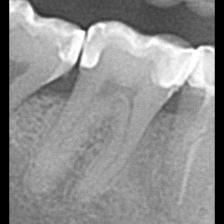


scary-windy-tangible-special-full-joint_95a1c5ab377665a79f57aed9b8501b10--f_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


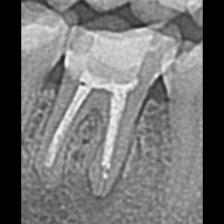


tight-amazing-regular-present-lazy-variation_ce83d0d123aacd78e3c38c06e7569070--f_4_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


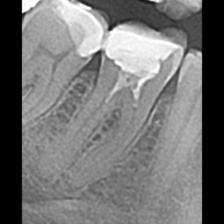


dirty-dangerous-low-pricey-unused-dust_ea68b780458257a04c07629caa0b1c94--m_4_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


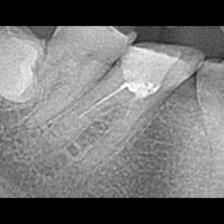





Images of teeth: 2-7, num of imgs: 11
overrated-fast-voracious-tangible-dry-drawing_f6995968efc09adef3f89122ec59c115--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


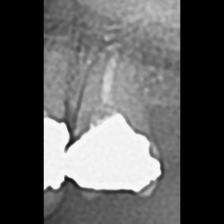


superficial-weak-handsome-nutritious-thirsty-upstairs_81bfa6ce0691cd29633b58a8036b173e--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


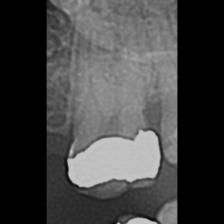


sophisticated-incredible-robust-roomy-red-bed_8cc8aa965d5e39177c6923c8e256a8e3--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


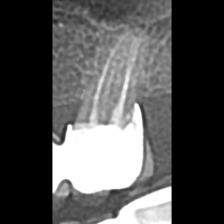


complex-frightened-rotten-mysterious-stormy-signal_452c698778d6f6cfbeb93ff93e869c17--f_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


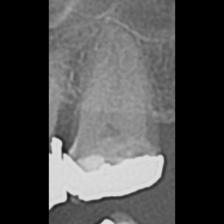


historical-hard-absent-rightful-paltry-permission_625cc3d9272da27fc4367d24dfe3ad43--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


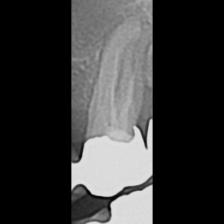


encouraging-busy-petite-joyous-parsimonious-belt_be2ddc06f0607204749181e52118cc17--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


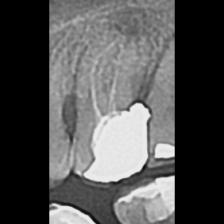


tiresome-sudden-inexpensive-dysfunctional-vigorous-designer_a381d73dd3dc38defc7dfe340a1767b1--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


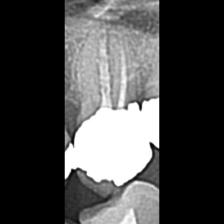


obnoxious-late-befitting-icy-exclusive-consist_c0439fb38be2385dd3b5e9a9a0f674f9--m_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


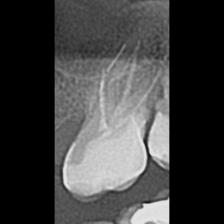


melodic-left-zonked-homeless-sordid-charity_7939d0c7a046211d70f475219f2e89c0--m_2_7.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


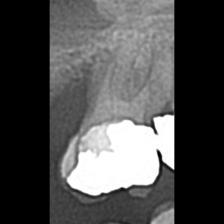


questionable-ludicrous-idiotic-deafening-wacky-district_23c5ee6910921e2807d95080885d451c--f_2_7.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


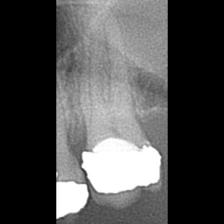


warm-irritating-miniature-stormy-messy-basket_e264ac9f2fc4776efc4a44404fc7d28e--f_2_7.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


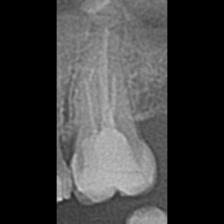





Images of teeth: 1-6, num of imgs: 10
energetic-stale-bitter-dull-possessive-fall_dae495a9e699c873355dc8abbf6e8a68--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


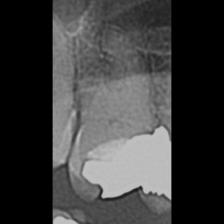


abrupt-cool-decorous-legal-exotic-exchange_aeeeca8f3ea76243daeac128e717dc43--m_1_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


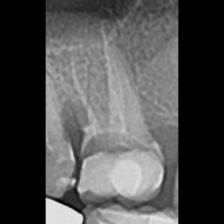


damaged-mushy-free-strong-short-annual_6d27dc09295d224b7e4d1a4942df1e3d--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


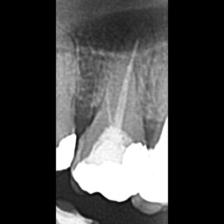


lively-lucky-tiny-rare-dusty-match_66f243f26292bdda437b1167e9500a31--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


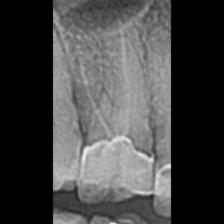


sloppy-slim-complete-jobless-temporary-mom_2f595d724c9ebef9b7891b0c984bc301--f_1_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


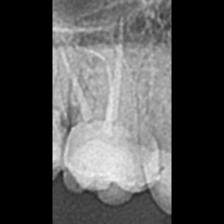


superficial-observant-gaping-scared-abhorrent-sensitive_b0a4881d0eb6ed541ad6387b894c38c3--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


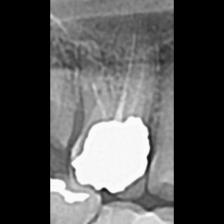


goofy-spicy-nimble-utter-half-strain_f6c2f91038da5ec2f89bf2a2892c4d78--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


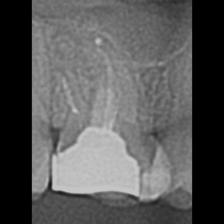


flippant-equable-cute-violet-willing-tip_9a57efefd144247dbe7bb4a16b5eec95--f_1_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


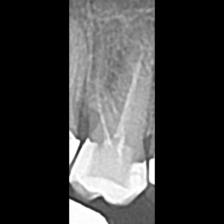


quick-hapless-satisfying-aback-groovy-radio_4c0bb32a21cedfbe3ec7f8e41425cb7c--m_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


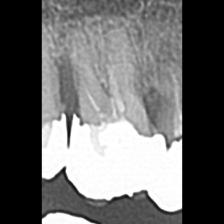


premium-charming-tidy-useless-screeching-priority_3ae7d5b2b68cf843e0cde08a842384bb--f_1_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


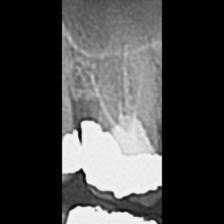





Images of teeth: 3-6, num of imgs: 8
dusty-resonant-bawdy-simple-upbeat-code_70e14a2fa2975c4e4545e8a79c720cf6--m_3_6.jpg
true-crown: 0.0, true-bridge: 1.0, predicted-crown: 1.0, predicted-bridge: 1.0


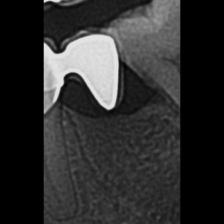


uptight-rare-greedy-poor-scrawny-championship_373094bfe283c6e068172d33c737b09e--f_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


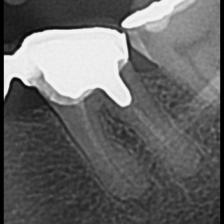


dashing-interesting-pale-coherent-available-opening_c479092939c6b3e9b571d8a6517a3dbf--m_3_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


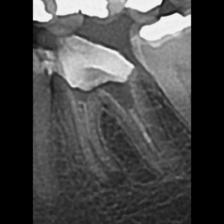


murky-angry-lush-gainful-halting-interaction_f5b2cf5dc8ba18a24f15a4efe9ae7a6d--f_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


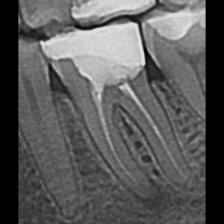


ugliest-quarrelsome-free-disgusted-outstanding-judgment_3bf9d8d8dfad5ac0dba23892da6babd2--f_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


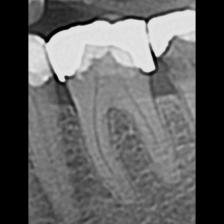


cheerful-gleaming-untidy-staking-unruly-manner_e18421cbfb12212dc7f278855dc8fb55--f_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


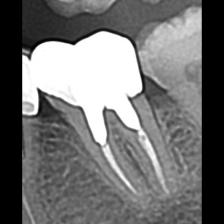


enchanted-addicted-open-agonizing-ugly-reply_8988f2a25ee04eadaa547b724fb7a953--m_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


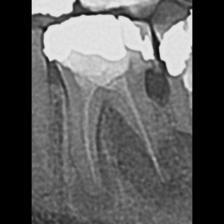


spooky-smiling-unknown-large-ruthless-question_16ffdc05b4728a170294b4500286821b--m_3_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


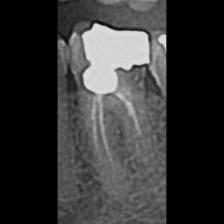





Images of teeth: 2-5, num of imgs: 6
measly-accidental-lacking-burly-breezy-impress_9e4e07dc28c18c1bba09e0d650397731--m_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


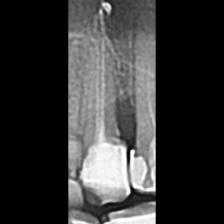


heartbreaking-rude-tangy-right-rebel-dream_2c187bde6bea809495d2a7c38d05f5dd--f_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


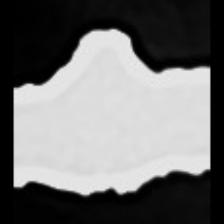


abrupt-cool-decorous-legal-exotic-exchange_aeeeca8f3ea76243daeac128e717dc43--m_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


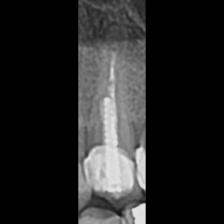


late-petite-warlike-bouncy-adjoining-business_6181d9a0d02210d3829a60a1cdd31786--m_2_5.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 0.0


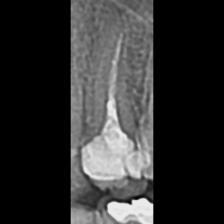


few-cuddly-enormous-obnoxious-outstanding-raise_4e4f2111692708e4712aea279bf7b487--f_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


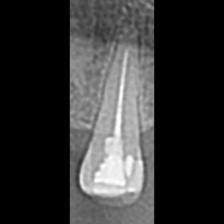


symptomatic-concerned-quixotic-rhetorical-cautious-make_f76dc6120473b7ff47172c75e0b7be10--f_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 0.0


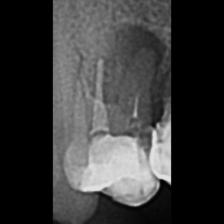

In [20]:
w_crown = rows_where_mismatch(anal_df, 'crown')
sus_teeth_crown = [(4,6), (2,7), (1,6), (3,6), (2,5), (4,6)]

img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
for sus_tooth in sus_teeth_crown:
  curr_w_crown = just_tooth(w_crown, quad=sus_tooth[0], index=sus_tooth[1])
  print(f'Images of teeth: {sus_tooth[0]}-{sus_tooth[1]}, num of imgs: {len(curr_w_crown)}')
  for idx_row in curr_w_crown.iterrows():
    row = idx_row[1]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path)
    print(f"{img_name}\ntrue-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}, predicted-crown: {row['predicted-crown']}, predicted-bridge: {row['predicted-bridge']}")
    display(image)
    print()
  print()
  print()
  print()

Images of teeth: 1-5, num of imgs: 4
breakable-itchy-romantic-warm-godly-engineering_470527af7b1fd5a2b76233d1a74259cf--m_1_5.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


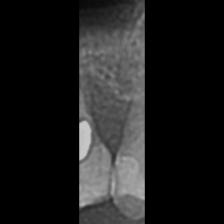


rainy-stimulating-upset-handsomely-spurious-employer_982316f0a4d03da977281d2734ed4573--m_1_5.jpg
true-crown: 0.0, true-bridge: 1.0, predicted-crown: 0.0, predicted-bridge: 0.0


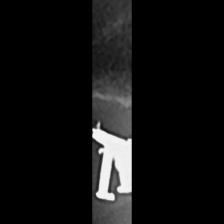


slow-maddening-abrupt-wretched-puny-milk_9196c50a8ca4447f6fbd8775ff7db50b--f_1_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 1.0


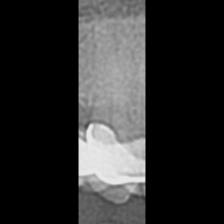


lonely-adamant-careful-pink-lively-database_58536e5a5dd89bdf990ab5f539fcc1dd--f_1_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 1.0


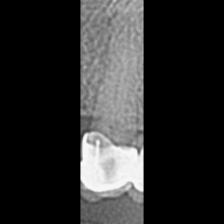





Images of teeth: 2-5, num of imgs: 2
heartbreaking-rude-tangy-right-rebel-dream_2c187bde6bea809495d2a7c38d05f5dd--f_2_5.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


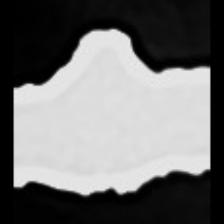


thoughtful-hulking-pale-alluring-domineering-sort_2e35b2a90f12e5d332dc50a65cae4636--m_2_5.jpg
true-crown: 0.0, true-bridge: 1.0, predicted-crown: 0.0, predicted-bridge: 0.0


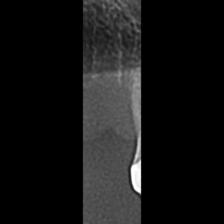





Images of teeth: 2-4, num of imgs: 2
thoughtful-hulking-pale-alluring-domineering-sort_2e35b2a90f12e5d332dc50a65cae4636--m_2_4.jpg
true-crown: 0.0, true-bridge: 1.0, predicted-crown: 0.0, predicted-bridge: 0.0


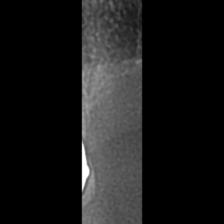


ordinary-ablaze-halting-parallel-shiny-box_a6934264c9e21e5533c92aff7bf81d76--m_2_4.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 1.0


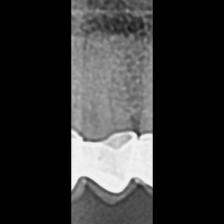





Images of teeth: 2-6, num of imgs: 2
willing-gamy-obnoxious-staking-overrated-economics_fd6eac97727adfbf6d0e76d1c5869847--f_2_6.jpg
true-crown: 0.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


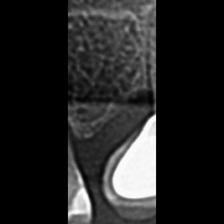


crabby-burly-talented-fearless-peaceful-finger_8e92f28e09f9be802db176a603f9932b--f_2_6.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


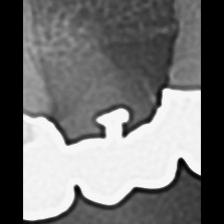





Images of teeth: 3-1, num of imgs: 1
bouncy-merciful-forgetful-obsequious-heavenly-dad_3737b6f7b4d948338cd353cfb40d51c5--f_3_1.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 0.0, predicted-bridge: 1.0


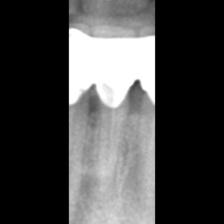





Images of teeth: 2-3, num of imgs: 1
valuable-honorable-bright-real-lame-unit_e0a6b1523d52f8a815679cdc6b06be15--m_2_3.jpg
true-crown: 1.0, true-bridge: 0.0, predicted-crown: 1.0, predicted-bridge: 1.0


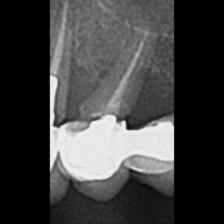





Images of teeth: 3-4, num of imgs: 1
nonchalant-temporary-jobless-barbarous-bent-work_cef2f1beb8bfd6f51b746c4752a3a4cd--f_3_4.jpg
true-crown: 0.0, true-bridge: 1.0, predicted-crown: 1.0, predicted-bridge: 0.0


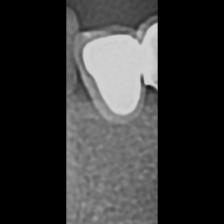

In [21]:
w_bridge = rows_where_mismatch(anal_df, 'bridge')
sus_teeth_bridge = [(1,5), (2,5), (2,4), (2,6), (3,1), (2,3), (3,4)]

img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
for sus_tooth in sus_teeth_bridge:
  curr_w_bridge = just_tooth(w_bridge, quad=sus_tooth[0], index=sus_tooth[1])
  print(f'Images of teeth: {sus_tooth[0]}-{sus_tooth[1]}, num of imgs: {len(curr_w_bridge)}')
  for idx_row in curr_w_bridge.iterrows():
    row = idx_row[1]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path)
    print(f"{img_name}\ntrue-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}, predicted-crown: {row['predicted-crown']}, predicted-bridge: {row['predicted-bridge']}")
    display(image)
    print()
  print()
  print()
  print()

In [ ]:
img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
for sus_tooth in sus_teeth:
  curr_w_fill = just_tooth(w_fill, quad=sus_tooth[0], index=sus_tooth[1])
  print(f'Images of teeth: {sus_tooth[0]}-{sus_tooth[1]}, num of imgs: {len(curr_w_fill)}')
  for idx_row in curr_w_fill.iterrows():
    row = idx_row[1]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path)
    print(f"{img_name}\ntrue-filling: {row['true-filling']}, true-endofilling: {row['true-endofilling']}, predicted-filling: {row['predicted-filling']}, predicted-endofilling: {row['predicted-endofilling']},\n true-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}")
    display(image)
    print()
  print()
  print()
  print()

quad  index  true-bridge  predicted-bridge
2     7      0.0          0.0                 218
      6      0.0          0.0                 214
3     7      0.0          0.0                 210
4     6      0.0          0.0                 208
1     7      0.0          0.0                 207
                                             ... 
2     5      0.0          1.0                   1
             1.0          0.0                   1
3     4      1.0          1.0                   1
                          0.0                   1
5     5      0.0          0.0                   1
Length: 77, dtype: int64
quad  index  true-endofilling  predicted-endofilling
3     7      0.0               0.0                      189
2     7      0.0               0.0                      187
      6      0.0               0.0                      185
1     7      0.0               0.0                      174
3     6      0.0               0.0                      170
                             

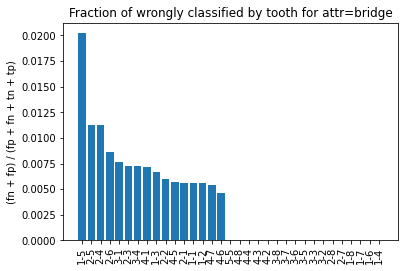

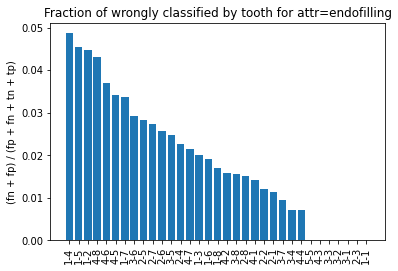

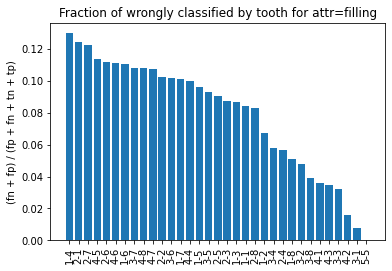

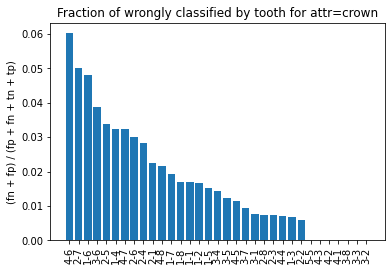

In [ ]:
for attr in attrs_of_interest:
  select = ['quad', 'index', f'true-{attr}', f'predicted-{attr}']
  cf_matrices = dict()             # first key => quad, second key => index, then 2d confusion array
  print(anal_df[select].value_counts())
  for val, cnt in anal_df[select].value_counts().iteritems():
    if not val[0] in cf_matrices: cf_matrices[val[0]] = dict()
    if not val[1] in cf_matrices[val[0]]: cf_matrices[val[0]][val[1]] = np.zeros((2,2))

    cf_matrices[val[0]][val[1]][int(val[2])][int(val[3])] = cnt
  
  classes = ('no', 'yes')
  l = []
  for quad in cf_matrices:
    for index in cf_matrices[quad]:
      if None:
        df_cm = pd.DataFrame(cf_matrices[quad][index], index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (4,3))
        sn.heatmap(df_cm, annot=True)
        plt.title(f'Confusion matrix for {attr}, teeth-id: {quad}-{index}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # datetime object containing current date and time
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

        plt.savefig(f'{dir_prefix}/graphics/Jan19/multilabel_model-{attr}-confusion_matrix-{dt_string}.png', dpi=1000)

      mat = cf_matrices[quad][index]
      l.append(((mat[0][1] + mat[1][0]) / mat.sum(), f'{quad}-{index}'))
  l.sort(reverse=True)
  x = [i[1] for i in l]
  y = [i[0] for i in l]
  plt.figure()
  plt.bar(x, y)
  plt.title(f'Fraction of wrongly classified by tooth for attr={attr}')
  plt.ylabel('(fn + fp) / (fp + fn + tn + tp)')
  plt.xticks(rotation = 90)
  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
  plt.savefig(f'{dir_prefix}/graphics/Jan19-sorted/bargrpah-{attr}-{dt_string}.png', dpi=1000)
  # plt.show()



age-int  true-bridge  predicted-bridge
43       0.0          0.0                 138
47       0.0          0.0                 137
42       0.0          0.0                 132
39       0.0          0.0                 127
33       0.0          0.0                 121
                                         ... 
35       1.0          1.0                   1
63       0.0          1.0                   1
36       1.0          1.0                   1
49       0.0          1.0                   1
50       0.0          1.0                   1
Length: 125, dtype: int64
age-int  true-endofilling  predicted-endofilling
43       0.0               0.0                      123
39       0.0               0.0                      120
47       0.0               0.0                      120
33       0.0               0.0                      117
30       0.0               0.0                      110
                                                   ... 
29       0.0               1.0              

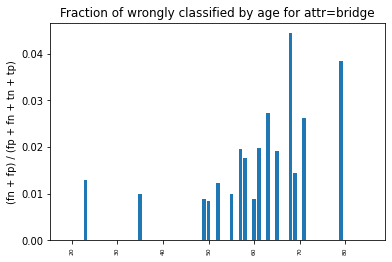

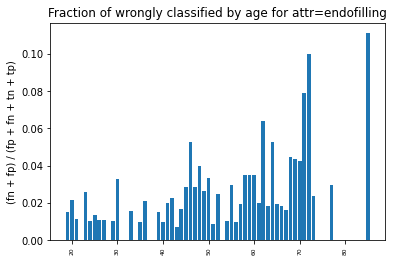

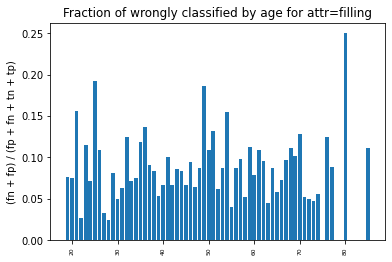

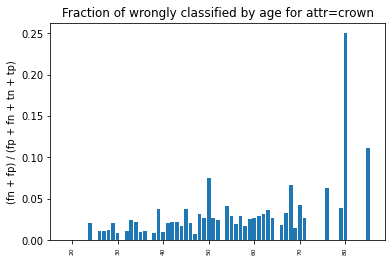

In [ ]:
anal_df['age-int'] = anal_df['age'].astype(int)
for attr in attrs_of_interest:
  select = ['age-int', f'true-{attr}', f'predicted-{attr}']
  cf_matrices = dict()             # first key => quad, second key => index, then 2d confusion array
  print(anal_df[select].value_counts())
  for val, cnt in anal_df[select].value_counts().iteritems():
    if not val[0] in cf_matrices: cf_matrices[val[0]] = np.zeros((2,2))

    cf_matrices[val[0]][int(val[1])][int(val[2])] = cnt
  
  classes = ('no', 'yes')
  l = []
  for age in cf_matrices:
      if None:
        df_cm = pd.DataFrame(cf_matrices[age], index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (4,3))
        sn.heatmap(df_cm, annot=True)
        plt.title(f'Confusion matrix for {attr}, age: {age}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # datetime object containing current date and time
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

        plt.savefig(f'{dir_prefix}/graphics/Jan19/multilabel_model-{attr}-confusion_matrix-{dt_string}.png', dpi=1000)

      mat = cf_matrices[age]
      l.append((age, (mat[0][1] + mat[1][0]) / mat.sum()))
  l.sort()
  x = [i[0] for i in l]
  y = [i[1] for i in l]
  plt.figure()
  plt.bar(x, y)
  plt.title(f'Fraction of wrongly classified by age for attr={attr}')
  plt.ylabel('(fn + fp) / (fp + fn + tn + tp)')
  plt.xticks(fontsize=6, rotation = 90)
  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
  plt.savefig(f'{dir_prefix}/graphics/Jan28-age/bargrpah-{attr}-{dt_string}.png', dpi=1000)
  # plt.show()